In [200]:
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
import quimb as q

import interaction_constants
from protocol_generator.interpolation_pg import InterpolationPG
from qubit_system.geometry import RegularLattice
from qubit_system.qubit_systems.evolving_qubit_system import EvolvingQubitSystem
from qubit_system.utils.ghz_states import CustomGHZState
from qubit_system.utils import states

optimised_protocols = {
    1: {
        'std': [2.65629869e+07, 1.10137775e+09, 2.10554803e+07, 1.53833774e+09, 1.43818374e+09, 1.15576644e+09],
        'alt': [1034883.35720177, 10746002.32511696, 13138604.21549956, 12611089.34283306, 14807475.81352524,
                12823830.46326383]

    },
    2: {
        'std': [1.59175109e+09, 4.40798493e+08, 8.22430687e+08, 1.52515077e+09, 2.72788764e+09, 2.08805395e+09],
        'alt': [8.94101353e+07, 1.34436283e+08, 3.17347152e+07, 1.90844269e+08, 9.70544131e+07, 8.64859020e+07]
    }
}

In [101]:
def get_e_qs(D: int, GHZ: str):
    N_RYD = 50
    C6 = interaction_constants.get_C6(N_RYD)
    
    LATTICE_SPACING = 1.5e-6
    
    N = 8
    assert D == 1 or D == 2, f"D has to be 1 or 2, not {D}"
    assert GHZ == "std" or GHZ == "alt", f"GHZ has to be std or alt, not {GHZ}"
    ghz_component = [True, True, True, True, True, True, True, True] if GHZ == "std" else None
    if D == 1:    
        geometry_shape = (8,)
        if GHZ == "alt":
            ghz_component = [True, False, True, False, True, False, True, False]
    elif D == 2:
        geometry_shape = (4, 2)
        if GHZ == "alt":
            ghz_component = [True, False, False, True, True, False, False, True]
        
    
    geometry = RegularLattice(shape=geometry_shape, spacing=LATTICE_SPACING)
    ghz_state = CustomGHZState(N, ghz_component)
    protocol = optimised_protocols[D][GHZ]
    
    t = 2e-6
    interpolation_timesteps = 3000
    t_list = np.linspace(0, t, interpolation_timesteps + 1)

    protocol_generator = InterpolationPG(t_list, kind="quadratic")
    Omega, Delta = protocol_generator.get_protocol(np.array(protocol))
    e_qs = EvolvingQubitSystem(
        N, C6, geometry,
        Omega, Delta,
        t_list,
        ghz_state=ghz_state
    )
    start_time = time.time()
    e_qs.solve()
    
    print(f"Solved in {time.time() - start_time:.3f}s")
    ghz_fidelity = e_qs.get_fidelity_with("ghz")
    
    print(f"{D}D {GHZ} fidelity: {ghz_fidelity:.5f}")
    return e_qs

e_qs_2d_alt = get_e_qs(2, "alt")
e_qs_1d_std = get_e_qs(1, "std")
e_qs_1d_alt = get_e_qs(1, "alt")

Solved in 7.036s
2D alt fidelity: 0.99998
Solved in 4.350s
1D std fidelity: 0.96210
Solved in 5.739s
1D alt fidelity: 0.79958


Solved in 4.237s
2d alt fidelity: 0.49993622185217274


In [106]:
def plot_formatter(func):
    def wrapper(*args, **kwargs):
        fig, ax = plt.subplots(figsize=(10, 4))
        return_value = func(*args, **kwargs)

        plt.xlabel('Time')
        ax.xaxis.set_major_formatter(ticker.EngFormatter('s'))
        try:
            ax.locator_params(nbins=5, axis='y')
        except TypeError:
            pass
        ax.locator_params(nbins=5, axis='x')
        plt.tight_layout()
        plt.grid()
        plt.show()
        return return_value
    return wrapper


In [107]:
@plot_formatter
def plot_eigenstate_populations(e_qs: EvolvingQubitSystem, log: bool):
    ax = plt.gca()
    states_list = states.get_states(e_qs.N)

    fidelities = []
    unique_labels = set()
    for i, state in enumerate(tqdm(states_list)):
        label = states.get_label_from_state(state)
        state_product_basis_index = states.get_product_basis_states_index(state)
        state_fidelities = [np.abs(_instantaneous_state.flatten()[state_product_basis_index]) ** 2
                            for _instantaneous_state in e_qs.solved_states]
            
        is_excited = [states.is_excited(_qubit) for _qubit in state]
        

        if all(is_excited[i] == e_qs.ghz_state.single_component[i] for i in range(e_qs.N)) \
             or all(is_excited[i] != e_qs.ghz_state.single_component[i] for i in range(e_qs.N)):
            fidelities.append(state_fidelities)

            plot_label = r"$P_{GHZ}$"
            color = 'r'
            linewidth = 1
        elif 'e' not in label :
            plot_label = r"$P_{" + f"{label.upper()[0]}" + "}$"
            color = 'g'
            linewidth = 1
        else:
            plot_label = 'Others'
            color = 'k'
            linewidth = 0.5

        if plot_label in unique_labels:
            plot_label = None
        else:
            unique_labels.add(plot_label)
            
        ax.plot(
            e_qs.solved_t_list,
            state_fidelities,
            label=plot_label,
            color=color,
            linewidth=linewidth,
            alpha=0.5
        )

    fidelities_sum = np.array(fidelities).sum(axis=0)
    ax.plot(e_qs.solved_t_list, fidelities_sum,
            label="$\sum P_{GHZ}$",
            color='C0', linestyle=":", linewidth=1, alpha=0.7)

    ax.set_ylabel("Population")
    ax.set_title("Basis state populations")
    ax.yaxis.set_ticks([0, 0.5, 1])
    if log:
        ax.set_yscale('log', basey=10)
        ax.set_ylim((1e-4, 2))
    else:
        ax.set_ylim((-0.1, 1.1))

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
    ax.legend(handles, labels)
 

1d std
1d alt
2d alt


C:\Users\harry\Anaconda3\envs\urop\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]


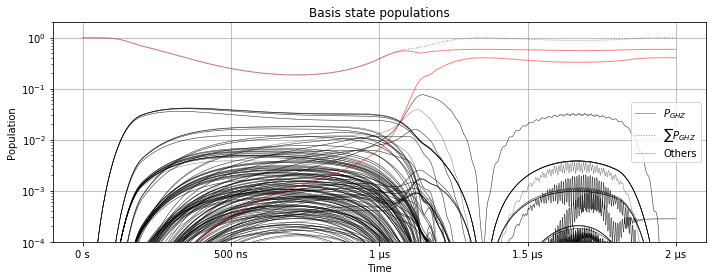

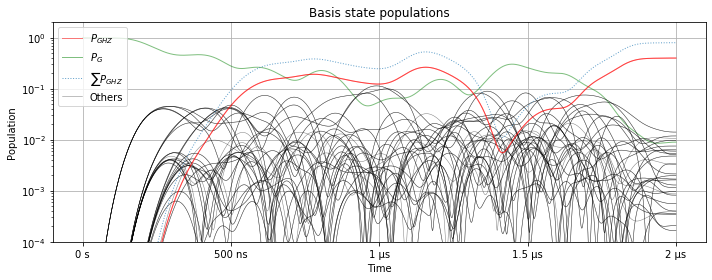

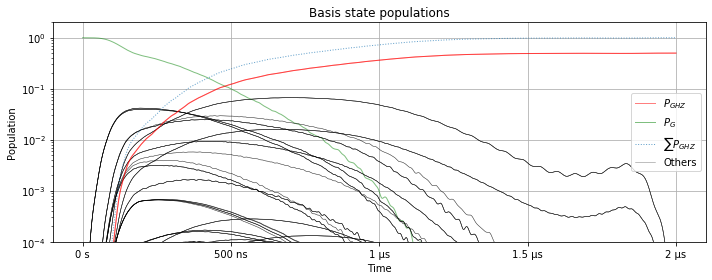

In [108]:
print("1d std")
plot_eigenstate_populations(e_qs_1d_std, log=True)

print("1d alt")
plot_eigenstate_populations(e_qs_1d_alt, log=True)

print("2d alt")
plot_eigenstate_populations(e_qs_2d_alt, log=True)

In [109]:
@plot_formatter
def plot_n_pc(e_qs: EvolvingQubitSystem):
    system_states = e_qs.solved_states
    N_pcs = []
    for state in tqdm(system_states):
        sum_powers = np.sum((np.power(np.abs(state), 4)))
        N_pc = 1 / sum_powers
        N_pcs.append(N_pc)
    ax = plt.gca()
    ax.plot(
        e_qs.solved_t_list, N_pcs,
        color='C0', linewidth=1
    )
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.axhline(1, color='k', linewidth=0.5, alpha=0.5)
    ax.axhline(2, color='k', linewidth=0.5, alpha=0.5)

    ax.set_title("Number of Principal Components")
    ax.set_ylabel("$N_{PC}$")


1d std
1d alt
2d alt


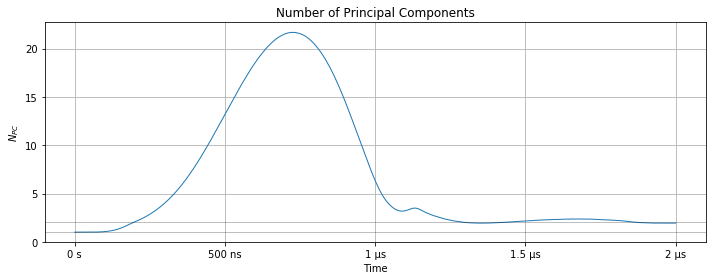

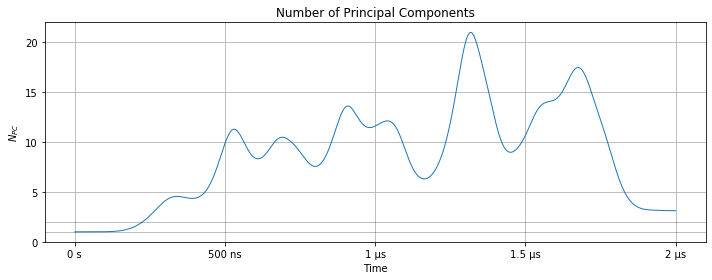

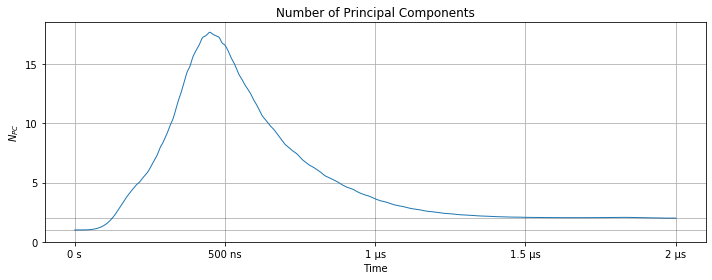

In [111]:
print("1d std")
plot_n_pc(e_qs_1d_std)

print("1d alt")
plot_n_pc(e_qs_1d_alt)

print("2d alt")
plot_n_pc(e_qs_2d_alt)


In [230]:
def plot_pxp_eigenstate(e_qs: EvolvingQubitSystem, log: bool = True):
    states_list = states.get_states(e_qs.N)
    unperturbed_eigenstates = [
        q.kron(*_state)
        for _state in states_list
    ]
    ts = [0.05e-6, 0.5e-6, 1e-6, 1.5e-6, 1.95e-6]
    solved_t_list = np.array(e_qs.solved_t_list)
    indices = [
        (np.abs(solved_t_list - _t)).argmin()
        for _t in ts
    ]
    ghz_state_component = q.quimbify(e_qs.ghz_state._get_components()[1], sparse=False)

    # print(indices)
    for i in indices:
        t = solved_t_list[i]
        Omega = e_qs.Omega[i]
        Delta = e_qs.Delta[i]
        hamiltonian = e_qs.get_hamiltonian(Omega, Delta)
        eigenenergies, inst_eigenstates = q.eigh(q.quimbify(hamiltonian, sparse=False))
        
        system_state = q.quimbify(e_qs.solved_states[i], sparse=False)
        
        energies = []
        ghz_overlaps = []
        instantaneous_eigenstate_populations = []
        for i, instantaneous_eigenstate in enumerate(inst_eigenstates):
            eigenenergy = eigenenergies[i]
            energies.append(eigenenergy)
            ghz_overlap = q.fidelity(ghz_state_component, instantaneous_eigenstate)
            ghz_overlaps.append(ghz_overlap)
            
            instantaneous_state_overlap = q.fidelity(system_state, instantaneous_eigenstate)
            instantaneous_eigenstate_populations.append(instantaneous_state_overlap)
        
        ax = plt.gca()
        color = np.log10(np.array(instantaneous_eigenstate_populations))
        # color = (color + color.min()) / (color.max() - color.min())
        
        norm = Normalize(vmin=-3, vmax=0)

        scatter = ax.scatter(energies, ghz_overlaps, c=color, cmap='viridis', norm=norm, s=10)
        ax.set_title(f"Instantaneous eigenstates $\phi$s at $t = {t * 1e6:.2f} \,$ $\mu$s.\n"
                     r" Colour represents eigenstate population "
                     r"$\log_{10} {\left|\langle \psi_t | \phi \rangle \right| }^2$.")
        ax.set_xlabel('$E$')
        ax.set_ylabel(r'${\left| \langle \mathrm{GHZ} | \phi \rangle \right| }^2$')
        if log:
            ax.set_ylim((1e-12, 1))
            ax.set_yscale('log', basey=10)
        else:
            ax.set_ylim((0, 1))
        plt.colorbar(scatter)
        plt.show()
        # return
        # print(hamiltonian)
        # plt.plot
        
    pass

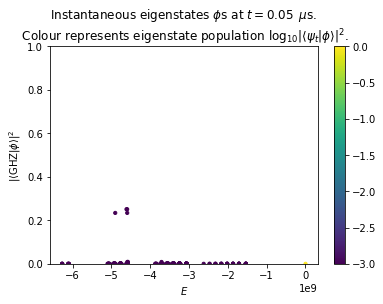

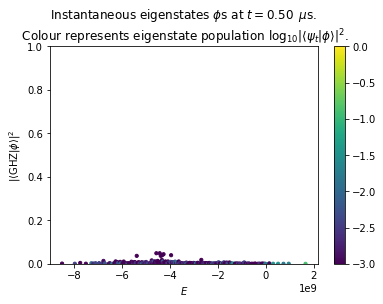

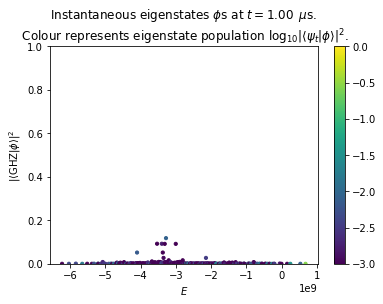

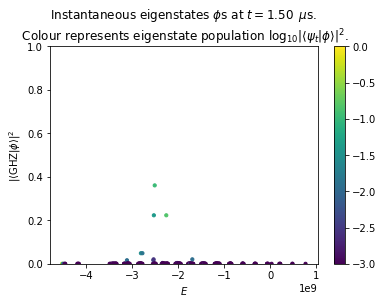

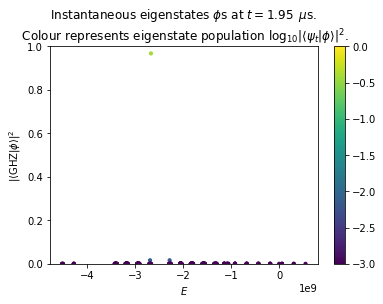

In [231]:
plot_pxp_eigenstate(e_qs_1d_std, log=False)

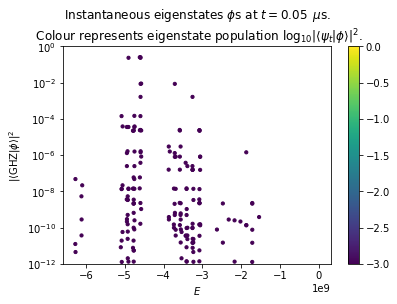

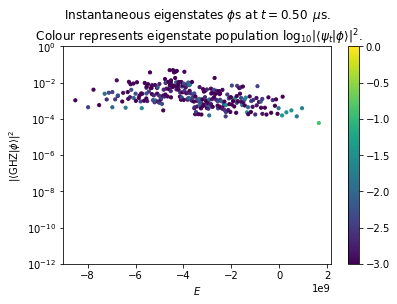

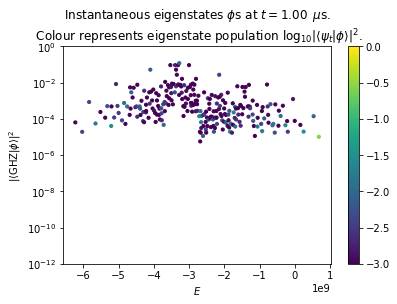

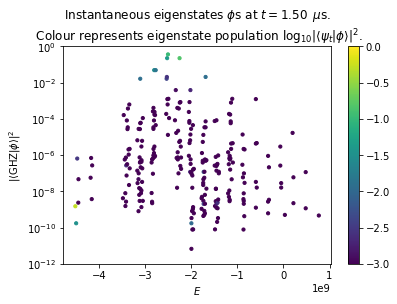

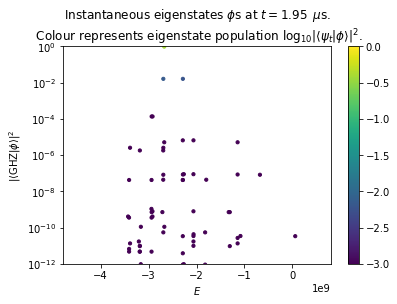

In [232]:
plot_pxp_eigenstate(e_qs_1d_std)

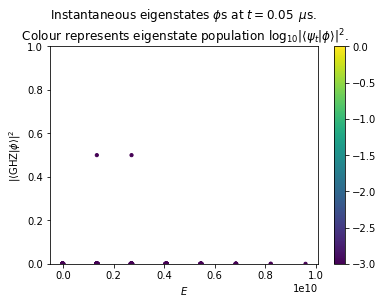

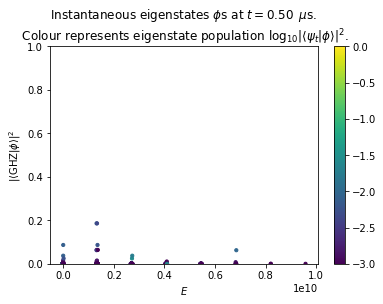

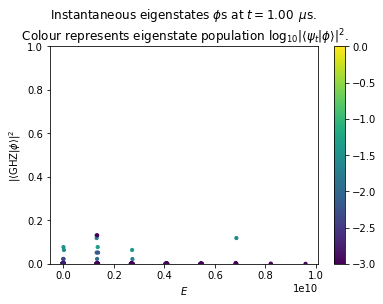

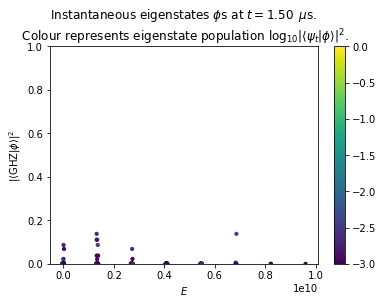

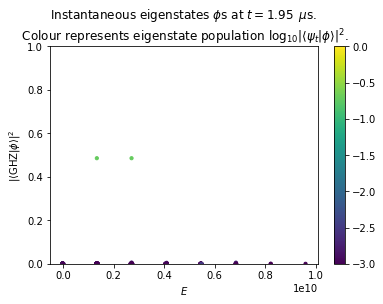

In [233]:
plot_pxp_eigenstate(e_qs_1d_alt, log=False)

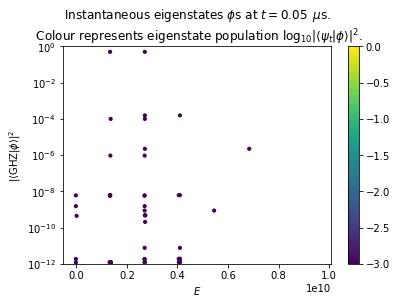

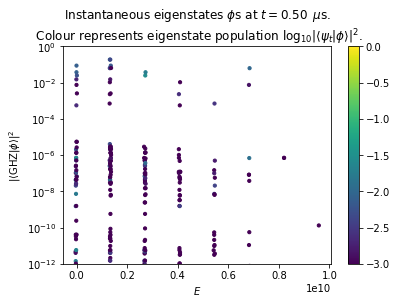

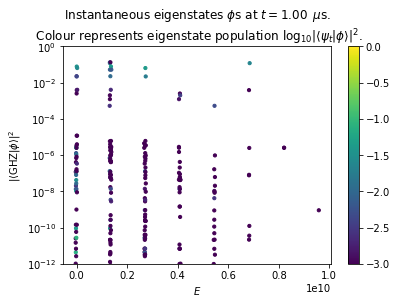

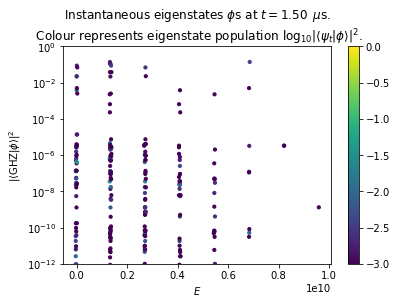

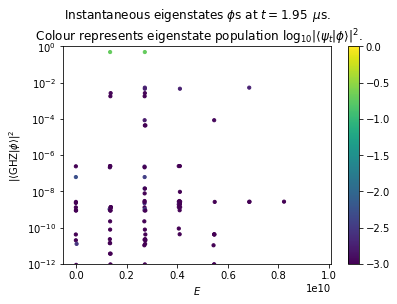

In [234]:
plot_pxp_eigenstate(e_qs_1d_alt)

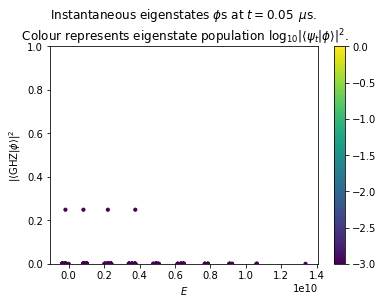

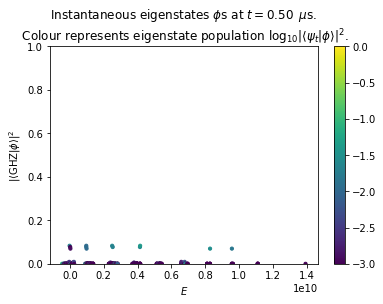

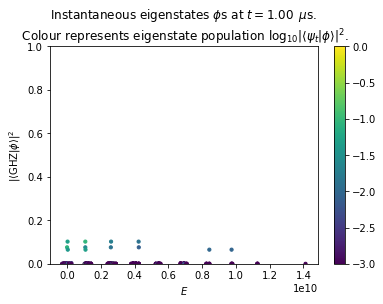

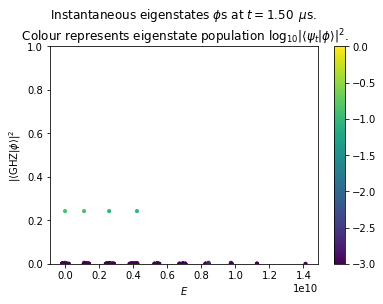

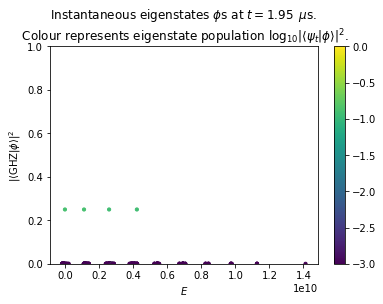

In [235]:
plot_pxp_eigenstate(e_qs_2d_alt, log=False)

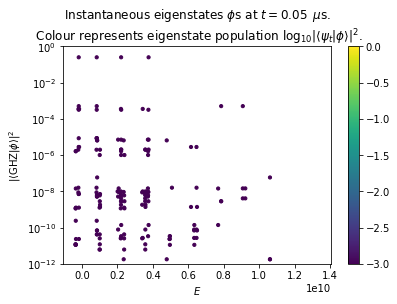

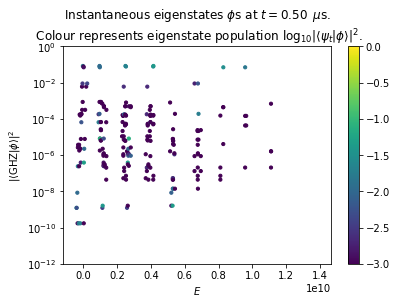

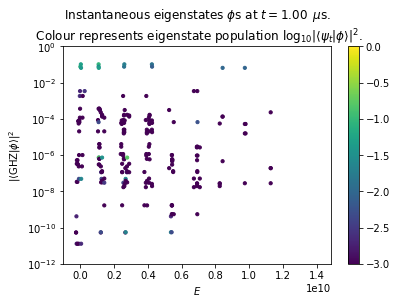

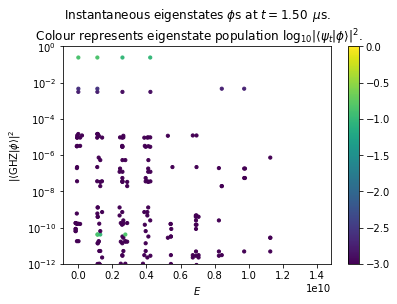

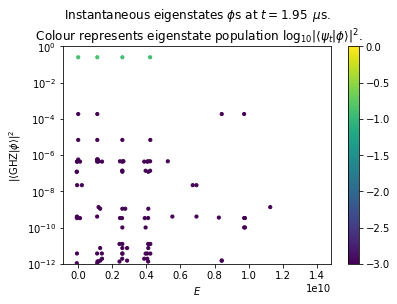

In [236]:
plot_pxp_eigenstate(e_qs_2d_alt)